/Users/a0000/Desktop/trade/Investar/Analyzer.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  krx = pd.read_sql(sql, self.conn)
/Users/a0000/Desktop/trade/Investar/Analyzer.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, self.conn)
/Users/a0000/Desktop/trade/Investar/Analyzer.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, self.conn)
/Users/a0000/Desktop/trade/Investar/Analyzer.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or dat

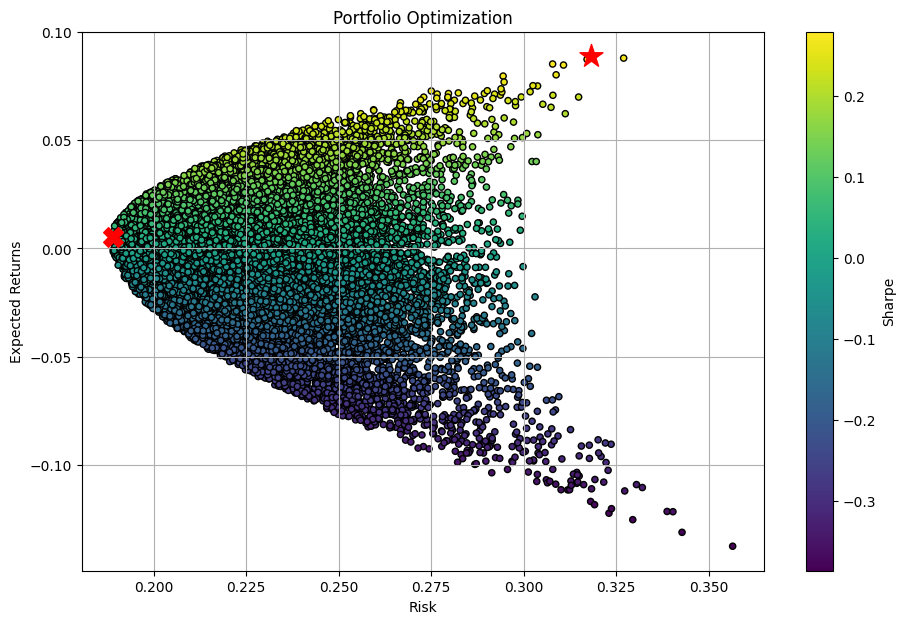

In [11]:
# 효율적인 투자선 구하기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Investar import Analyzer

mk = Analyzer.MarketDB()
stocks = ['삼성전자','SK하이닉스', '현대자동차', 'NAVER']
df = pd.DataFrame()
for s in stocks:
    df[s] = mk.get_daily_price(s, '2022-01-25', '2023-12-09')['close']

daily_ret = df.pct_change()
annual_ret = daily_ret.mean() * 252
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 252

port_ret = []
port_risk = []
port_weight = []
sharpe_ratio = []

# 몬테카를로 시뮬레이션
for _ in range(20000):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)

    returns = np.dot(weights, annual_ret)
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))

    port_ret.append(returns)
    port_risk.append(risk)
    port_weight.append(weights)
    sharpe_ratio.append(returns/risk)

portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe':sharpe_ratio}
for i, s in enumerate(stocks):
    portfolio[s] = [weights[i] for weight in port_weight]
df = pd.DataFrame(portfolio)
df = df[['Returns', 'Risk', 'Sharpe'] + [s for s in stocks]]

max_sharpe = df.loc[df['Sharpe'] == df['Sharpe'].max()]
min_risk = df.loc[df['Risk'] == df['Risk'].min()]

df.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis', edgecolors='k', figsize=(11,7), grid=True)
plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r', marker='*', s=300)
plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='r', marker='X', s=200)
plt.title('Portfolio Optimization')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

/Users/a0000/Desktop/trade/Investar/Analyzer.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  krx = pd.read_sql(sql, self.conn)
/Users/a0000/Desktop/trade/Investar/Analyzer.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, self.conn)


end_date is initialized to '2023-12-10'


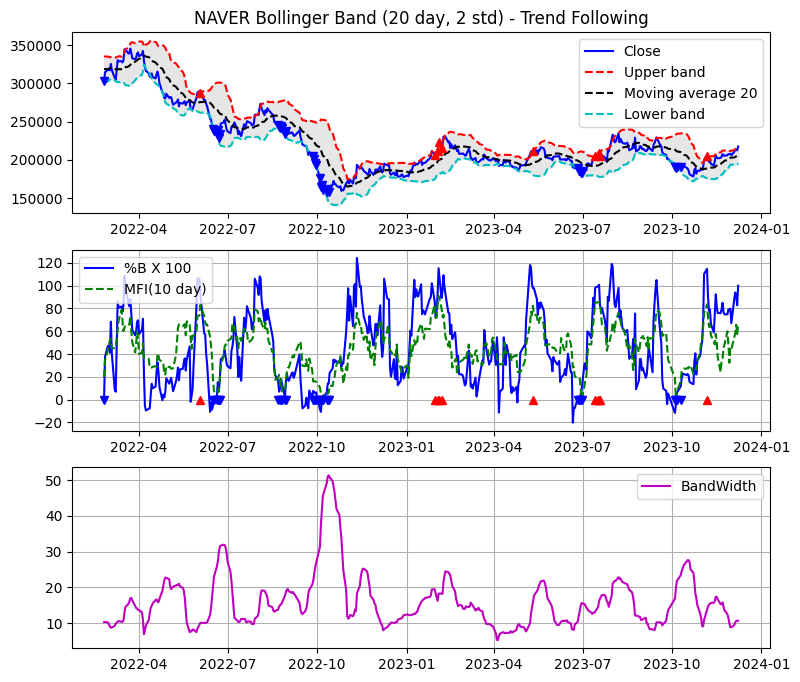

In [13]:
# 추세 추종 매매 구현
import matplotlib.pyplot as plt
from Investar import Analyzer

mk = Analyzer.MarketDB()
df = mk.get_daily_price('NAVER', '2022-01-25')

df['MA20'] = df['close'].rolling(window=20).mean()
df['stddev'] = df['close'].rolling(window=20).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
# Percent B (%b) : 주가가 볼린져 밴드의 어에 위치하는지에 대한 지표 <하단 볼린저 밴드(0), 중간 볼린저 밴드(0.5), 상단 볼린저 밴드(1)>
df['PB'] = (df['close'] - df['lower']) / (df['upper'] - df['lower'])
# 볼린져 밴드 폭
df['bandwidth'] = (df['upper'] - df['lower']) / df['MA20'] * 100
# MFI(현금흐름지표)
df['TP'] = (df['high'] + df['low'] + df['close']) / 3
df['PMF'] = 0 # Positive Money Flow
df['NMF'] = 0 # Negative Money Flow
for i in range(len(df.close)-1):
    if df.TP.values[i] < df.TP.values[i+1]:
        df.PMF.values[i+1] = df.TP.values[i+1] * df.volume.values[i+1]
        df.NMF.values[i+1] = 0
    else:
        df.NMF.values[i+1] = df.TP.values[i+1] * df.volume.values[i+1]
        df.PMF.values[i+1] = 0
df['MFR'] = df.PMF.rolling(window=10).sum() / df.NMF.rolling(window=10).sum() # Money Flow Ratio / 10일 기준
df['MFI10'] = 100 - 100 / (1 + df['MFR'])
df = df[19:]

plt.figure(figsize=(9,8))
# 볼린저 밴드
plt.subplot(3,1,1)
plt.title('NAVER Bollinger Band (20 day, 2 std) - Trend Following')
plt.plot(df.index, df['close'], color='#0000ff', label='Close')
plt.plot(df.index, df['upper'], 'r--', label='Upper band')
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label='Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
for i in range(len(df.close)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:
        plt.plot(df.index.values[i], df.close.values[i], 'r^')
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:
        plt.plot(df.index.values[i], df.close.values[i], 'bv')
plt.legend(loc='best')

# Percent B (%b) <하단 볼린저 밴드(0), 중간 볼린저 밴드(0.5), 상단 볼린저 밴드(1)>
# 현금흐름지표 (Money Flow Index [MFI])
plt.subplot(3,1,2)
plt.plot(df.index, df['PB'] * 100, color='b', label='%B X 100')
plt.plot(df.index, df['MFI10'], 'g--', label='MFI(10 day)')
plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120])
for i in range(len(df.close)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')

# 볼린저 밴드 폭
plt.subplot(3,1,3)
plt.plot(df.index, df['bandwidth'], color='m', label='BandWidth')
plt.grid(True)
plt.legend(loc='best')
plt.show()

/Users/a0000/Desktop/trade/Investar/Analyzer.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  krx = pd.read_sql(sql, self.conn)
/Users/a0000/Desktop/trade/Investar/Analyzer.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, self.conn)


end_date is initialized to '2023-12-11'


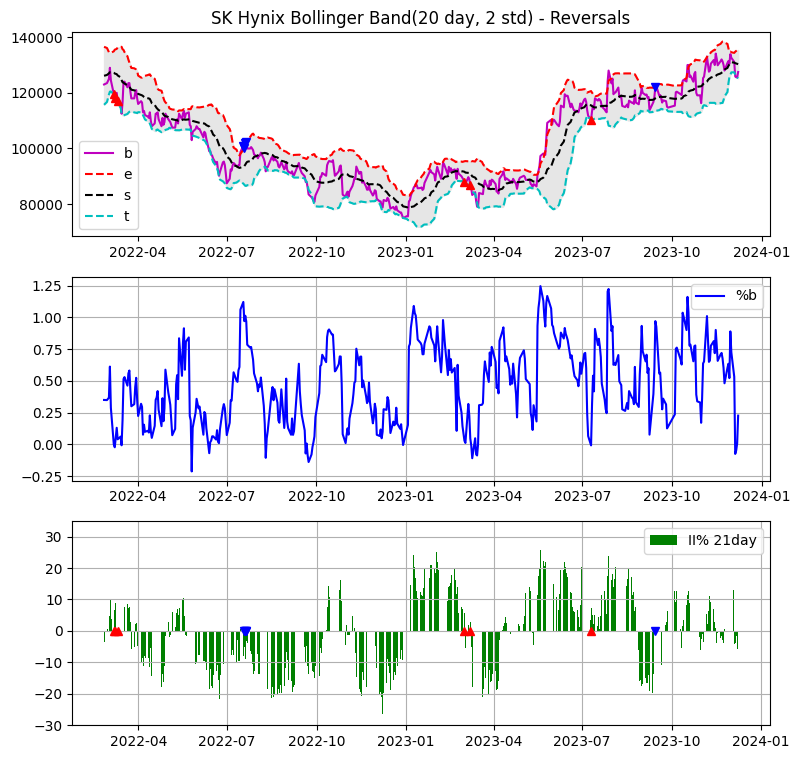

In [16]:
import matplotlib.pyplot as plt
from Investar import Analyzer

mk = Analyzer.MarketDB()
df = mk.get_daily_price('SK하이닉스', '2022-01-25')

df['MA20'] = df['close'].rolling(window=20).mean()
df['stddev'] = df['close'].rolling(window=20).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['PB'] = (df['close'] - df['lower']) / (df['upper'] - df['lower'])

df['II'] = (2*df['close']-df['high']-df['low']) / (df['high']-df['low']) * df['volume'] # 일중강도 (Intraday Intensity)
df['IIP21'] = df['II'].rolling(window=21).sum() / df['volume'].rolling(window=21).sum()*100 # 일중강도율 (Intraday Intensity Percent)
df = df.dropna()

plt.figure(figsize=(9,9))
plt.subplot(3,1,1)
plt.title('SK Hynix Bollinger Band(20 day, 2 std) - Reversals')
plt.plot(df.index, df['close'], 'm', label='Close')
plt.plot(df.index, df['upper'], 'r--', label='Upper band')
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label='Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
for i in range(len(df.close)):
    if df.PB.values[i] < 0.05 and df.IIP21.values[i] > 0:
        plt.plot(df.index.values[i], df.close.values[i], 'r^')
    elif df.PB.values[i] > 0.95 and df.IIP21.values[i] < 0:
        plt.plot(df.index.values[i], df.close.values[i], 'bv')
plt.legend('best')

plt.subplot(3,1,2)
plt.plot(df.index, df['PB'], 'b', label='%b')
plt.grid(True)
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.bar(df.index, df['IIP21'], color='g', label='II% 21day')
for i in range(len(df.close)):
    if df.PB.values[i] < 0.05 and df.IIP21.values[i] > 0:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.PB.values[i] > 0.95 and df.IIP21.values[i] < 0:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# 삼중창 매매 시스템

/Users/a0000/Desktop/trade/Investar/Analyzer.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  krx = pd.read_sql(sql, self.conn)
/Users/a0000/Desktop/trade/Investar/Analyzer.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, self.conn)


end_date is initialized to '2023-12-11'


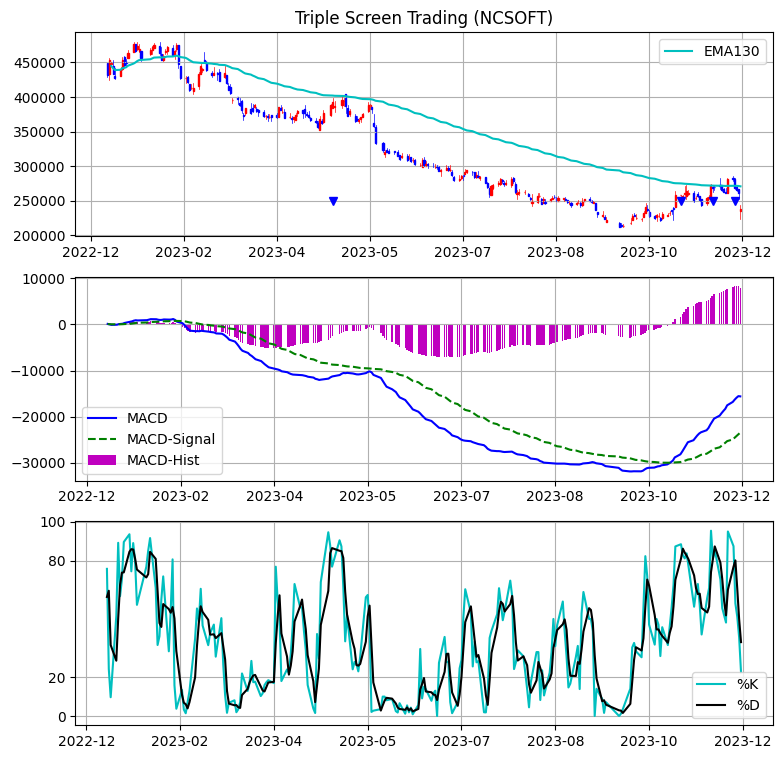

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from Investar import Analyzer

mk = Analyzer.MarketDB()
df = mk.get_daily_price('엔씨소프트', '2023-01-01')

ema60 = df.close.ewm(span=60).mean()
ema130 = df.close.ewm(span=130).mean()
macd = ema60 - ema130
signal = macd.ewm(span=45).mean()
macdhist = macd - signal
df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal, macdhist=macdhist).dropna()

df['number'] = df.index.map(mdates.date2num)
ohlc = df[['number', 'open', 'high', 'low', 'close']]

ndays_high = df.high.rolling(window=14, min_periods=1).max()
ndays_low = df.low.rolling(window=14, min_periods=1).min()

fast_k = (df.close - ndays_low) / (ndays_high - ndays_low) * 100
slow_d = fast_k.rolling(window=3).mean()
df = df.assign(fast_k=fast_k, slow_d=slow_d).dropna()

plt.figure(figsize=(9,9))
p1 = plt.subplot(3,1,1)
plt.title('Triple Screen Trading (NCSOFT)')
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['ema130'], color='c', label='EMA130')
for i in range(1, len(df.close)):
    if (df.ema130.values[i-1] < df.ema130.values[i]) and (df.slow_d.values[i-1] >= 20) and (df.slow_d.values[i] < 20):
        plt.plot(df.number.values[i], 250000, 'r^')
    elif (df.ema130.values[i-1] > df.ema130.values[i]) and (df.slow_d.values[i-1] <= 80) and (df.slow_d.values[i] > 80):
        plt.plot(df.number.values[i], 250000, 'bv')
plt.legend(loc='best')

p2 = plt.subplot(3,1,2)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.bar(df.number, df['macdhist'], color='m', label='MACD-Hist')
plt.plot(df.number, df['macd'], color='b', label='MACD')
plt.plot(df.number, df['signal'], 'g--', label='MACD-Signal')
plt.legend(loc='best')

p3 = plt.subplot(3,1,3)
plt.grid(True)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['fast_k'], color='c', label='%K')
plt.plot(df.number, df['slow_d'], color='k', label='%D')
plt.yticks([0, 20, 80, 100])
plt.legend(loc='best')
plt.show()

# 듀얼모멘텀

In [7]:
import pandas as pd
import pymysql
from datetime import datetime
from datetime import timedelta
from Investar import Analyzer

class DualMomentum:
    def __init__(self):
        """생성자: KRX 종목코드(codes)를 구하기 위한 MarkgetDB 객체 생성"""
        self.mk = Analyzer.MarketDB()
    
    def get_rltv_momentum(self, start_date, end_date, stock_count):
        """특정 기간 동안 수익률이 제일 높았던 stock_count 개의 종목들 (상대 모멘텀)
            - start_date  : 상대 모멘텀을 구할 시작일자 ('2020-01-01')   
            - end_date    : 상대 모멘텀을 구할 종료일자 ('2020-12-31')
            - stock_count : 상대 모멘텀을 구할 종목수
        """       
        connection = pymysql.connect(host='localhost', port=3306, 
            db='INVESTAR', user='root', passwd='myPassword', autocommit=True)
        cursor = connection.cursor()
        
        # 사용자가 입력한 시작일자를 DB에서 조회되는 일자로 보정 
        sql = f"select max(date) from daily_price where date <= '{start_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result[0] is None):
            print ("start_date : {} -> returned None".format(sql))
            return
        start_date = result[0].strftime('%Y-%m-%d')


        # 사용자가 입력한 종료일자를 DB에서 조회되는 일자로 보정
        sql = f"select max(date) from daily_price where date <= '{end_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result[0] is None):
            print ("end_date : {} -> returned None".format(sql))
            return
        end_date = result[0].strftime('%Y-%m-%d')


        # KRX 종목별 수익률을 구해서 2차원 리스트 형태로 추가
        rows = []
        columns = ['code', 'company', 'old_price', 'new_price', 'returns']
        for _, code in enumerate(self.mk.codes):            
            sql = f"select close from daily_price "\
                f"where code='{code}' and date='{start_date}'"
            cursor.execute(sql)
            result = cursor.fetchone()
            if (result is None):
                continue
            old_price = int(result[0])
            sql = f"select close from daily_price "\
                f"where code='{code}' and date='{end_date}'"
            cursor.execute(sql)
            result = cursor.fetchone()
            if (result is None):
                continue
            new_price = int(result[0])
            returns = (new_price / old_price - 1) * 100
            rows.append([code, self.mk.codes[code], old_price, new_price, 
                returns])


        # 상대 모멘텀 데이터프레임을 생성한 후 수익률순으로 출력
        df = pd.DataFrame(rows, columns=columns)
        df = df[['code', 'company', 'old_price', 'new_price', 'returns']]
        df = df.sort_values(by='returns', ascending=False)
        df = df.head(stock_count)
        df.index = pd.Index(range(stock_count))
        connection.close()
        print(df)
        print(f"\nRelative momentum ({start_date} ~ {end_date}) : "\
            f"{df['returns'].mean():.2f}% \n")
        return df
    
    def get_abs_momentum(self, rltv_momentum, start_date, end_date):
        """특정 기간 동안 상대 모멘텀에 투자했을 때의 평균 수익률 (절대 모멘텀)
            - rltv_momentum : get_rltv_momentum() 함수의 리턴값 (상대 모멘텀)
            - start_date    : 절대 모멘텀을 구할 매수일 ('2020-01-01')   
            - end_date      : 절대 모멘텀을 구할 매도일 ('2020-12-31')
        """
        stockList = list(rltv_momentum['code'])        
        connection = pymysql.connect(host='localhost', port=3306, 
            db='INVESTAR', user='root', passwd='myPassword', autocommit=True)
        cursor = connection.cursor()


        # 사용자가 입력한 매수일을 DB에서 조회되는 일자로 변경 
        sql = f"select max(date) from daily_price "\
            f"where date <= '{start_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result[0] is None):
            print ("{} -> returned None".format(sql))
            return
        start_date = result[0].strftime('%Y-%m-%d')


        # 사용자가 입력한 매도일을 DB에서 조회되는 일자로 변경 
        sql = f"select max(date) from daily_price "\
            f"where date <= '{end_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result[0] is None):
            print ("{} -> returned None".format(sql))
            return
        end_date = result[0].strftime('%Y-%m-%d')


        # 상대 모멘텀의 종목별 수익률을 구해서 2차원 리스트 형태로 추가
        rows = []
        columns = ['code', 'company', 'old_price', 'new_price', 'returns']
        for _, code in enumerate(stockList):            
            sql = f"select close from daily_price "\
                f"where code='{code}' and date='{start_date}'"
            cursor.execute(sql)
            result = cursor.fetchone()
            if (result is None):
                continue
            old_price = int(result[0])
            sql = f"select close from daily_price "\
                f"where code='{code}' and date='{end_date}'"
            cursor.execute(sql)
            result = cursor.fetchone()
            if (result is None):
                continue
            new_price = int(result[0])
            returns = (new_price / old_price - 1) * 100
            rows.append([code, self.mk.codes[code], old_price, new_price,
                returns])


        # 절대 모멘텀 데이터프레임을 생성한 후 수익률순으로 출력
        df = pd.DataFrame(rows, columns=columns)
        df = df[['code', 'company', 'old_price', 'new_price', 'returns']]
        df = df.sort_values(by='returns', ascending=False)
        connection.close()
        print(df)
        print(f"\nAbasolute momentum ({start_date} ~ {end_date}) : "\
            f"{df['returns'].mean():.2f}%")
        return

In [14]:
dm = DualMomentum()
rm = dm.get_rltv_momentum('2022-10-01', '2022-12-31', 10)

/Users/a0000/Desktop/trade/Investar/Analyzer.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  krx = pd.read_sql(sql, self.conn)


     code  company  old_price  new_price      returns
0  224060      더코디        400       9470  2267.500000
1  025620  제이준코스메틱        415       6030  1353.012048
2  021040    대호특수강        567       5320   838.271605
3  090370     메타랩스        617       2445   296.272285
4  012320   경동인베스트      29800      98500   230.536913
5  014990     인디에프        571       1510   164.448336
6  032190    다우데이타      14050      30950   120.284698
7  007700  F&F 홀딩스      14650      30450   107.849829
8  227610   아우딘퓨쳐스       2195       4510   105.466970
9  138040  메리츠금융지주      20850      42700   104.796163

Relative momentum (2022-09-30 ~ 2022-12-29) : 558.84% 



In [15]:
am = dm.get_abs_momentum(rm, '2023-01-01', '2023-03-31')

     code  company  old_price  new_price    returns
6  032190    다우데이타      30950      49950  61.389338
1  025620  제이준코스메틱       6030       7360  22.056385
3  090370     메타랩스       2445       2760  12.883436
4  012320   경동인베스트      98500     107100   8.730964
2  021040    대호특수강       5320       5140  -3.383459
9  138040  메리츠금융지주      42700      38600  -9.601874
7  007700  F&F 홀딩스      30450      25100 -17.569787
0  224060      더코디       9470       6750 -28.722281
5  014990     인디에프       1510       1019 -32.516556
8  227610   아우딘퓨쳐스       4510       1768 -60.798226

Abasolute momentum (2022-12-29 ~ 2023-03-31) : -4.75%
